Импортируем необходимые библиотеки:

In [9]:
import pandas as pd
# from pprint import pprint
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import numpy as np
import pickle
from math import radians, sin, cos, sqrt, atan2
import json

# Шаг 1: выбор темы

- У меня есть комнатные растения, и я несколько раз покупала их на авито. 
Цены на этом сайте выставляют кое-как, да и в целом, помимо картинок, которые можно анализировать разве что с помощью нейросетей, карточки объявлений редко содержат много содержательной информации. Однако, мне было интересно посмотреть, как выглядит средняя цена на растение, от чего она зависит. Была и идея посмотреть на тренд этой цены, если получится - даже посчитать уровень инфляции цены комнатных цветов на авито, научиться его предсказывать)

- Кроме того, карточки содержат информацию про популярность объявления. Мне хотелось посмотреть, зависит ли популярность объявления от цены, от времени, прошедшего с момента публикации, от отзывов на продавца.

- В результате я пришла к тому, что надо бы распарсить авито самостоятельно, а потом поисследовать, что получится поисследовать. Ни один из готовых датасетов не подходил мне, т.к. у меня был специфический запрос - я хотела происследовать комнатные цветы на авито.

# Шаг 2: сбор данных

### Данные получены с помощью парсинга авито.

https://www.avito.com

1) Кодом прошлась по 50 поисковым страницам по запросу "Комнатные цветы". Собрала ссылки для объявлений. Использовала селениум, чтобы загрузить страницу, и BeautifulSoup, чтобы распарсить.
2) Зашла по ссылке на каждое из объявлений, собрала данные по цене, продавцу, местоположению товара, числу просмотров.
3) Решила получить географические координаты места для того, чтобы придумать дополнительные признаки. Для этого воспользовалась API Яндекс.Геокодера. Зарегистрировалась, получила API-ключ на 1000 запросов. Это естественным образом ограничило максимальный размер моей выборки.

P.S. файлы avito_parsing.ipynb (пункты 1 и 2) и adding_coordinates.ipynb (пункт 3) не содержат выполненных ячеек. Это потому что для того, чтобы нормально все спарсить и экономно использовать API, мне пришлось раскидывать код по большому числу ячеек, сохранять промежуточные состояния с помощью модуля pickle, и т.д. Результирующий датасет я сохранила в json-файл.

In [8]:
# Загружаем данные из JSON
with open('plant_data_dict.json', 'r') as json_file:
    plant_data_dict = json.load(json_file)

Что у нас есть:
- Цена
- Несколько ли товаров в продаже
- Средняя оценка продавца
- Число отзывов о продавце
- Местоположение товара
- Время публикации
- Число просмотров у объявления
- Число просмотров у объявления за последний день (обновлено 2 июня 2024)

# Шаг 3: предварительная обработка

Создадим датафрейм:

In [22]:
columns = ['Ссылка', 'Цена', 'Несколько товаров', 'Рейтинг продавца', 'Число отзывов', 'Адрес', 'Время публикации', 'Просмотры', 'Просмотры (посл. день)']

rows = []

for url, values in plant_data_dict.items():
    row = [url] + values
    rows.append(pd.Series(row, index=columns))

df = pd.concat(rows, axis=1).T

df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день)
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2 000₽,None,"5,0",38 отзывов,"Московская обл., Мытищи, ул. Мира",·28 мая в 00:34,16просмотров,(+1сегодня)
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2 400₽,None,"4,9",36 отзывов,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 мая в 08:00,124просмотра,(+1сегодня)
2,https://www.avito.ru/naberezhnye_chelny/rasten...,None,None,"5,0",156 отзывов,"Республика Татарстан, Набережные Челны, 28-й к...",·30 мая в 12:12,193просмотра,(+15сегодня)
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50₽,несколько,None,None,"Республика Татарстан, Набережные Челны, пр-т В...",·24 мая в 16:13,571просмотр,(+22сегодня)
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50₽,None,"5,0",34 отзыва,"Республика Татарстан, Набережные Челны, посёло...",·30 мая в 10:51,114просмотров,(+11сегодня)
...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700₽,None,"5,0",2 отзыва,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 мая в 09:17,89просмотров,(+10сегодня)
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150₽,несколько,None,None,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 мая в 12:22,36просмотров,(+8сегодня)
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40₽,несколько,None,None,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 мая в 09:39,64просмотра,(+1сегодня)
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200₽,None,"5,0",19 отзывов,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 мая в 12:56,3621просмотр,(+1сегодня)


Преобразуем последние 3 колонки:

In [23]:
# Словарь для преобразования месяцев
month_translation = {
    'января': '01',
    'февраля': '02',
    'марта': '03',
    'апреля': '04',
    'мая': '05',
    'июня': '06',
    'июля': '07',
    'августа': '08',
    'сентября': '09',
    'октября': '10',
    'ноября': '11',
    'декабря': '12'
}

# Функция для замены названий месяцев на числовые значения
def replace_month(date_str):
    if not pd.isna(date_str):
        for ru_month, num_month in month_translation.items():
            date_str = date_str.replace(ru_month, num_month)
    return date_str

# Преобразование строки даты в формат 'DD MM YYYY'
df['Время публикации'] = df['Время публикации'].apply(replace_month)
df['Время публикации'] = df['Время публикации'] + ' 2024'

# Преобразование в datetime
df['Datetime'] = pd.to_datetime(df['Время публикации'], format='·%d %m в %H:%M %Y', errors='coerce')
df['Datetime'] = df['Datetime'].where(pd.notna(df['Datetime']), None)
df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день),Datetime
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2 000₽,None,"5,0",38 отзывов,"Московская обл., Мытищи, ул. Мира",·28 05 в 00:34 2024,16просмотров,(+1сегодня),2024-05-28 00:34:00
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2 400₽,None,"4,9",36 отзывов,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 05 в 08:00 2024,124просмотра,(+1сегодня),2024-05-30 08:00:00
2,https://www.avito.ru/naberezhnye_chelny/rasten...,None,None,"5,0",156 отзывов,"Республика Татарстан, Набережные Челны, 28-й к...",·30 05 в 12:12 2024,193просмотра,(+15сегодня),2024-05-30 12:12:00
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50₽,несколько,None,None,"Республика Татарстан, Набережные Челны, пр-т В...",·24 05 в 16:13 2024,571просмотр,(+22сегодня),2024-05-24 16:13:00
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50₽,None,"5,0",34 отзыва,"Республика Татарстан, Набережные Челны, посёло...",·30 05 в 10:51 2024,114просмотров,(+11сегодня),2024-05-30 10:51:00
...,...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700₽,None,"5,0",2 отзыва,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 05 в 09:17 2024,89просмотров,(+10сегодня),2024-05-29 09:17:00
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150₽,несколько,None,None,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 05 в 12:22 2024,36просмотров,(+8сегодня),2024-05-30 12:22:00
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40₽,несколько,None,None,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 05 в 09:39 2024,64просмотра,(+1сегодня),2024-05-29 09:39:00
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200₽,None,"5,0",19 отзывов,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 05 в 12:56 2024,3621просмотр,(+1сегодня),2024-05-29 12:56:00


Посмотрим на символы в колонке "Цена":

In [24]:
s = set()
for val in df['Цена']:
    if not pd.isna(val):
        for letter in val:
            s.add(letter)
s

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\xa0', '₽'}

Преобразуем тип данных в 4-х колонках:

In [25]:
def drop_nonnum(s):
    set_nums = set(['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'])
    if not pd.isna(s):
        for letter in s:
            if letter not in set_nums:
                s = s.replace(letter, '').replace(letter, '')
        s = int(s)
    return s

df['Цена'] = df['Цена'].apply(drop_nonnum)
df['Число отзывов'] = df['Число отзывов'].apply(drop_nonnum)
df['Просмотры'] = df['Просмотры'].apply(drop_nonnum)
df['Просмотры (посл. день)'] = df['Просмотры (посл. день)'].apply(drop_nonnum)

df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день),Datetime
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2000.0,None,"5,0",38.0,"Московская обл., Мытищи, ул. Мира",·28 05 в 00:34 2024,16.0,1.0,2024-05-28 00:34:00
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2400.0,None,"4,9",36.0,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 05 в 08:00 2024,124.0,1.0,2024-05-30 08:00:00
2,https://www.avito.ru/naberezhnye_chelny/rasten...,NaN,None,"5,0",156.0,"Республика Татарстан, Набережные Челны, 28-й к...",·30 05 в 12:12 2024,193.0,15.0,2024-05-30 12:12:00
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,несколько,None,NaN,"Республика Татарстан, Набережные Челны, пр-т В...",·24 05 в 16:13 2024,571.0,22.0,2024-05-24 16:13:00
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,None,"5,0",34.0,"Республика Татарстан, Набережные Челны, посёло...",·30 05 в 10:51 2024,114.0,11.0,2024-05-30 10:51:00
...,...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700.0,None,"5,0",2.0,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 05 в 09:17 2024,89.0,10.0,2024-05-29 09:17:00
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150.0,несколько,None,NaN,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 05 в 12:22 2024,36.0,8.0,2024-05-30 12:22:00
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40.0,несколько,None,NaN,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 05 в 09:39 2024,64.0,1.0,2024-05-29 09:39:00
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200.0,None,"5,0",19.0,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 05 в 12:56 2024,3621.0,1.0,2024-05-29 12:56:00


Сделаем категориальную переменную 'Несколько товаров' правильной:

In [26]:
def mult_goods(s):
    if pd.isna(s):
        return 0
    else:
        return 1

df['Несколько товаров'] = df['Несколько товаров'].apply(mult_goods)

In [27]:
df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день),Datetime
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2000.0,0,"5,0",38.0,"Московская обл., Мытищи, ул. Мира",·28 05 в 00:34 2024,16.0,1.0,2024-05-28 00:34:00
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2400.0,0,"4,9",36.0,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 05 в 08:00 2024,124.0,1.0,2024-05-30 08:00:00
2,https://www.avito.ru/naberezhnye_chelny/rasten...,NaN,0,"5,0",156.0,"Республика Татарстан, Набережные Челны, 28-й к...",·30 05 в 12:12 2024,193.0,15.0,2024-05-30 12:12:00
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,1,None,NaN,"Республика Татарстан, Набережные Челны, пр-т В...",·24 05 в 16:13 2024,571.0,22.0,2024-05-24 16:13:00
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,0,"5,0",34.0,"Республика Татарстан, Набережные Челны, посёло...",·30 05 в 10:51 2024,114.0,11.0,2024-05-30 10:51:00
...,...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700.0,0,"5,0",2.0,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 05 в 09:17 2024,89.0,10.0,2024-05-29 09:17:00
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150.0,1,None,NaN,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 05 в 12:22 2024,36.0,8.0,2024-05-30 12:22:00
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40.0,1,None,NaN,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 05 в 09:39 2024,64.0,1.0,2024-05-29 09:39:00
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200.0,0,"5,0",19.0,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 05 в 12:56 2024,3621.0,1.0,2024-05-29 12:56:00


 Поправим "Рейтинг продавца":

In [28]:
def rating_change(s):
    if pd.isna(s):
        return s
    else:
        return float(s.replace(',', '.'))

df['Рейтинг продавца'] = df['Рейтинг продавца'].apply(rating_change)
df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день),Datetime
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2000.0,0,5.0,38.0,"Московская обл., Мытищи, ул. Мира",·28 05 в 00:34 2024,16.0,1.0,2024-05-28 00:34:00
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2400.0,0,4.9,36.0,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 05 в 08:00 2024,124.0,1.0,2024-05-30 08:00:00
2,https://www.avito.ru/naberezhnye_chelny/rasten...,NaN,0,5.0,156.0,"Республика Татарстан, Набережные Челны, 28-й к...",·30 05 в 12:12 2024,193.0,15.0,2024-05-30 12:12:00
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,1,NaN,NaN,"Республика Татарстан, Набережные Челны, пр-т В...",·24 05 в 16:13 2024,571.0,22.0,2024-05-24 16:13:00
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,0,5.0,34.0,"Республика Татарстан, Набережные Челны, посёло...",·30 05 в 10:51 2024,114.0,11.0,2024-05-30 10:51:00
...,...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700.0,0,5.0,2.0,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 05 в 09:17 2024,89.0,10.0,2024-05-29 09:17:00
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150.0,1,NaN,NaN,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 05 в 12:22 2024,36.0,8.0,2024-05-30 12:22:00
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40.0,1,NaN,NaN,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 05 в 09:39 2024,64.0,1.0,2024-05-29 09:39:00
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200.0,0,5.0,19.0,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 05 в 12:56 2024,3621.0,1.0,2024-05-29 12:56:00


# + Шаг 5: создание новых признаков (внутри шага 3)

In [29]:
# Для того, чтобы посчитать расстояние между координатами, пользовалась этим:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

# Загружаем координаты

with open('coords_nums.pkl', 'rb') as file:
    coords_nums = pickle.load(file)

# Словарь городов-миллионников России с их координатами
cities = {
    "Москва": (55.7558, 37.6176),
    "Санкт-Петербург": (59.9343, 30.3351),
    "Новосибирск": (55.0084, 82.9357),
    "Екатеринбург": (56.8389, 60.6057),
    "Казань": (55.8304, 49.0661),
    "Нижний Новгород": (56.2965, 43.9361),
    "Челябинск": (55.1644, 61.4368),
    "Самара": (53.1959, 50.1000),
    "Ростов-на-Дону": (47.2357, 39.7015),
    "Уфа": (54.7388, 55.9721),
    "Красноярск": (56.0153, 92.8932),
    "Воронеж": (51.6615, 39.2003),
    "Пермь": (58.0105, 56.2502),
    "Волгоград": (48.7080, 44.5133)
}

def haversine(coord1, coord2):
    # Конвертация координат из градусов в радианы
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    
    # Разница между координатами
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Формула гаверсина для вычисления расстояния
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Радиус Земли в километрах
    distance = R * c
    return distance

def find_nearest_city(lon, lat):
    min_distance = float('inf')
    nearest_city_distance = None
    moscow_spb_distance = None
    
    # Координаты Москвы и Санкт-Петербурга
    moscow_coords = cities["Москва"]
    spb_coords = cities["Санкт-Петербург"]
    
    for city, coords in cities.items():
        distance = haversine((lat, lon), coords)
        if distance < min_distance:
            min_distance = distance
            nearest_city_distance = distance
            
    # Расстояния до Москвы и Санкт-Петербурга
    distance_to_moscow = haversine((lat, lon), moscow_coords)
    distance_to_spb = haversine((lat, lon), spb_coords)
    
    moscow_spb_distance = min(distance_to_moscow, distance_to_spb)
    
    return nearest_city_distance, moscow_spb_distance

closest_city_dists = []
msk_spb_dists = []

for url in df['Ссылка']:
    if url in coords_nums:
        lat, lon = coords_nums[url]
        nearest_city_distance, moscow_spb_distance = find_nearest_city(lat, lon)
        closest_city_dists.append(nearest_city_distance)
        msk_spb_dists.append(moscow_spb_distance)
    else:
        closest_city_dists.append(pd.NA)
        msk_spb_dists.append(pd.NA)

df['Расст. до миллионника'] = closest_city_dists
df['Расст. до Мск/Спб'] = msk_spb_dists

Заполним пропуски для числа отзывов нулями: (т.к. их 0)


Заполним пропуски для рейтинга средним значением:

In [31]:
df['Число отзывов'] = df['Число отзывов'].fillna(0.0)
df['Рейтинг продавца'] = df['Рейтинг продавца'].fillna(df['Рейтинг продавца'].mean())
df

,Ссылка,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Адрес,Время публикации,Просмотры,Просмотры (посл. день),Datetime,Расст. до миллионника,Расст. до Мск/Спб
0,https://www.avito.ru/mytischi/rasteniya/komnat...,2000.0,0,5.00000,38.0,"Московская обл., Мытищи, ул. Мира",·28 05 в 00:34 2024,16.0,1.0,2024-05-28 00:34:00,19.094441,19.094441
1,https://www.avito.ru/mytischi/rasteniya/komnat...,2400.0,0,4.90000,36.0,"Московская обл., Мытищи, Юбилейная ул., 35к2",·30 05 в 08:00 2024,124.0,1.0,2024-05-30 08:00:00,17.282858,17.282858
2,https://www.avito.ru/naberezhnye_chelny/rasten...,NaN,0,5.00000,156.0,"Республика Татарстан, Набережные Челны, 28-й к...",·30 05 в 12:12 2024,193.0,15.0,2024-05-30 12:12:00,<NA>,<NA>
3,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,1,4.93125,0.0,"Республика Татарстан, Набережные Челны, пр-т В...",·24 05 в 16:13 2024,571.0,22.0,2024-05-24 16:13:00,209.354258,924.014954
4,https://www.avito.ru/naberezhnye_chelny/rasten...,50.0,0,5.00000,34.0,"Республика Татарстан, Набережные Челны, посёло...",·30 05 в 10:51 2024,114.0,11.0,2024-05-30 10:51:00,202.23386,917.111359
...,...,...,...,...,...,...,...,...,...,...,...,...
2081,https://www.avito.ru/myski/rasteniya/komnatnye...,700.0,0,5.00000,2.0,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·29 05 в 09:17 2024,89.0,10.0,2024-05-29 09:17:00,346.297126,3158.613422
2082,https://www.avito.ru/myski/rasteniya/komnatnye...,150.0,1,4.93125,0.0,"Кемеровская обл., Мысковский г.о., Мыски, ул. ...",·30 05 в 12:22 2024,36.0,8.0,2024-05-30 12:22:00,345.365383,3157.712044
2083,https://www.avito.ru/myski/rasteniya/tsvety_ko...,40.0,1,4.93125,0.0,"Кемеровская обл., Мысковский г.о., Мыски, Олим...",·29 05 в 09:39 2024,64.0,1.0,2024-05-29 09:39:00,346.204735,3158.558273
2084,https://www.avito.ru/mytischi/rasteniya/komnat...,200.0,0,5.00000,19.0,"Московская обл., Мытищи, ул. Веры Волошиной, 56",·29 05 в 12:56 2024,3621.0,1.0,2024-05-29 12:56:00,16.61569,16.61569


In [47]:
df_clean = df.drop(columns=['Ссылка', 'Адрес', 'Время публикации']).dropna(axis='index')
df_clean = df_clean[df_clean['Цена'] <= 10000]

In [48]:
df_clean

,Цена,Несколько товаров,Рейтинг продавца,Число отзывов,Просмотры,Просмотры (посл. день),Datetime,Расст. до миллионника,Расст. до Мск/Спб,Дата_без_времени
0,2000.0,0,5.00000,38.0,16.0,1.0,2024-05-28 00:34:00,19.094441,19.094441,2024-05-28
1,2400.0,0,4.90000,36.0,124.0,1.0,2024-05-30 08:00:00,17.282858,17.282858,2024-05-30
3,50.0,1,4.93125,0.0,571.0,22.0,2024-05-24 16:13:00,209.354258,924.014954,2024-05-24
4,50.0,0,5.00000,34.0,114.0,11.0,2024-05-30 10:51:00,202.23386,917.111359,2024-05-30
5,250.0,0,4.60000,98.0,548.0,4.0,2024-05-29 08:57:00,203.234517,918.098364,2024-05-29
...,...,...,...,...,...,...,...,...,...,...
2081,700.0,0,5.00000,2.0,89.0,10.0,2024-05-29 09:17:00,346.297126,3158.613422,2024-05-29
2082,150.0,1,4.93125,0.0,36.0,8.0,2024-05-30 12:22:00,345.365383,3157.712044,2024-05-30
2083,40.0,1,4.93125,0.0,64.0,1.0,2024-05-29 09:39:00,346.204735,3158.558273,2024-05-29
2084,200.0,0,5.00000,19.0,3621.0,1.0,2024-05-29 12:56:00,16.61569,16.61569,2024-05-29


# Шаг 4: Визуализация

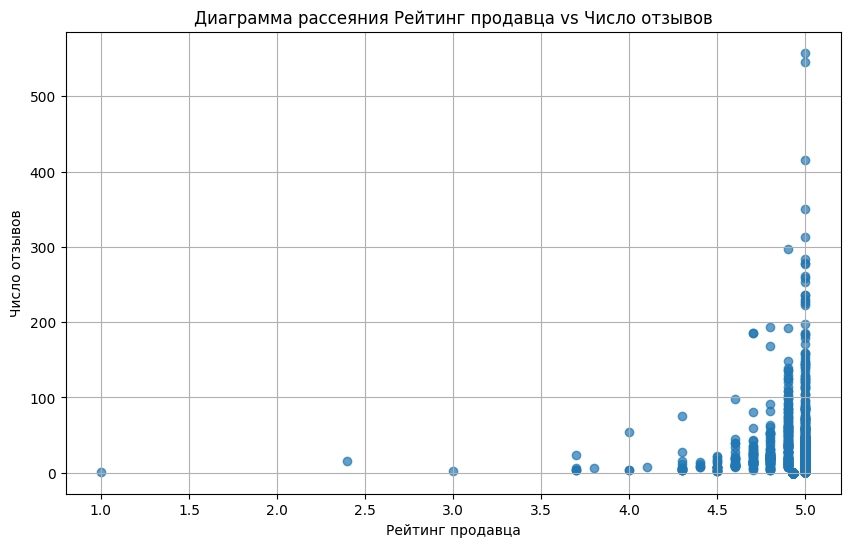

In [49]:
# Диаграмма рассеяния для анализа взаимосвязи между числовыми столбцами
plt.figure(figsize=(10, 6))
plt.scatter(df['Рейтинг продавца'], df['Число отзывов'], alpha=0.7)
plt.title('Диаграмма рассеяния Рейтинг продавца vs Число отзывов')
plt.xlabel('Рейтинг продавца')
plt.ylabel('Число отзывов')
plt.grid(True)
plt.show()

Гипотеза: чем больше отзывов, тем выше рейтинг.

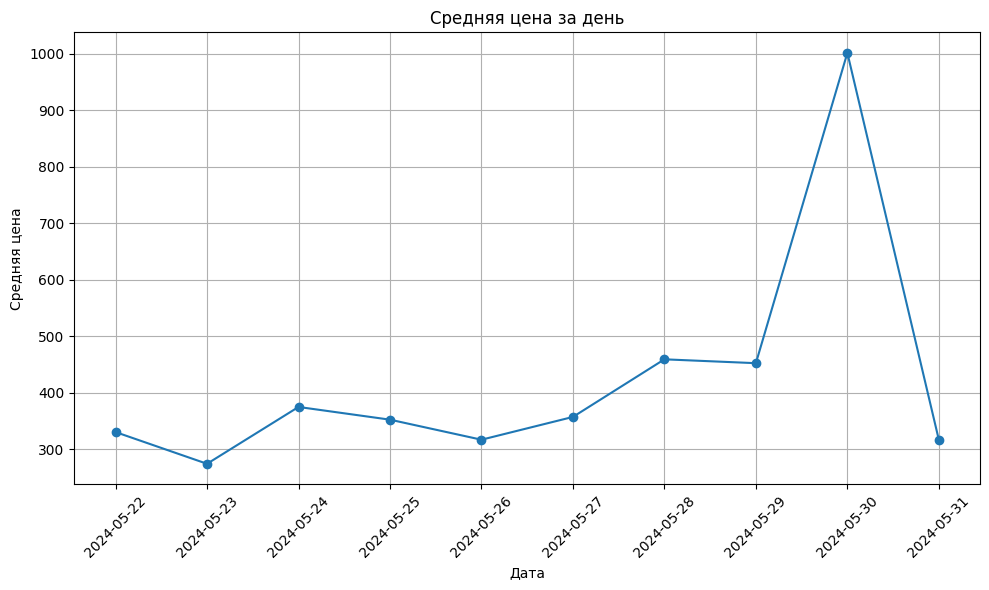

In [50]:
# Извлечение даты без времени
df['Дата_без_времени'] = df['Datetime'].dt.date

# Группировка данных по дате и вычисление средней цены
average_price_by_date = df.groupby('Дата_без_времени')['Цена'].mean()

# Построение графика средней цены за день
plt.figure(figsize=(10, 6))
average_price_by_date.plot(kind='line', marker='o')
plt.title('Средняя цена за день')
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Гипотеза: разброс цены слишком высокий, чтобы говорить о тренде.

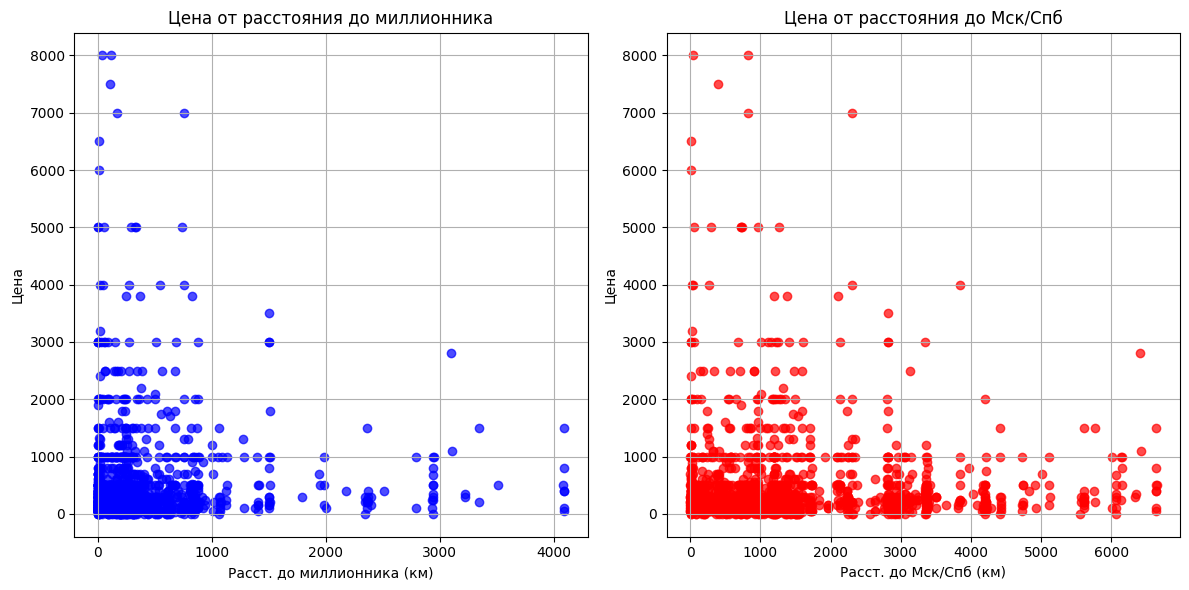

In [51]:
# Построение графика зависимости цены от расстояния до миллионника
plt.figure(figsize=(12, 6))

# График для расстояния до миллионника
plt.subplot(1, 2, 1)
plt.scatter(df_clean['Расст. до миллионника'], df_clean['Цена'], color='blue', alpha=0.7)
plt.title('Цена от расстояния до миллионника')
plt.xlabel('Расст. до миллионника (км)')
plt.ylabel('Цена')
plt.grid(True)

# График для расстояния до Мск/Спб
plt.subplot(1, 2, 2)
plt.scatter(df_clean['Расст. до Мск/Спб'], df_clean['Цена'], color='red', alpha=0.7)
plt.title('Цена от расстояния до Мск/Спб')
plt.xlabel('Расст. до Мск/Спб (км)')
plt.ylabel('Цена')
plt.grid(True)

plt.tight_layout()
plt.show()

Гипотеза: с увеличением расстояния до миллионника или до Спб/Мск уменьшается средняя цена.

# 6. Гипотезы

In [54]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Корреляция Пирсона
correlation_millionnik = stats.pearsonr(df_clean['Расст. до миллионника'], df_clean['Цена'])
correlation_msk_spb = stats.pearsonr(df_clean['Расст. до Мск/Спб'], df_clean['Цена'])

print("Корреляция Пирсона между ценой и расстоянием до миллионника:", correlation_millionnik)
print("Корреляция Пирсона между ценой и расстоянием до Мск/Спб:", correlation_msk_spb)


Корреляция Пирсона между ценой и расстоянием до миллионника: PearsonRResult(statistic=0.05595128325853993, pvalue=0.018566202103777893)
Корреляция Пирсона между ценой и расстоянием до Мск/Спб: PearsonRResult(statistic=0.009085642977609668, pvalue=0.7024737686827569)
